In [295]:
import gpytorch
import torch
import math
import matplotlib.pyplot as plt

### Show GP samples in 1D problem

In [296]:
train_x = torch.linspace(0, 1, 100)[torch.randint(0,100, (10,))]
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
test_x = torch.linspace(0, 1, 51)
use_periodic = True

In [297]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        if use_periodic:
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [298]:
def fit(model, likelihood):
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(50):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

fit(model, likelihood)

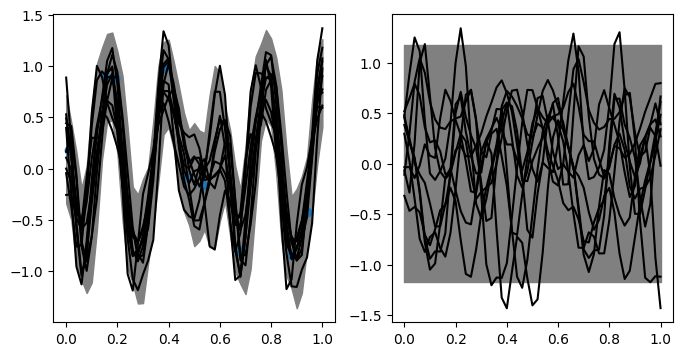

In [299]:
model.eval()
likelihood.eval()

@torch.no_grad()
def plot_samples_1d(ax, dist, num_samples):
    lower, upper = dist.confidence_region()
    for _ in range(num_samples):
        z_sample = dist.sample()
        ax.plot(test_x, z_sample, color="k")
    
    ax.fill_between(test_x, lower.numpy(), upper.numpy(), color="grey")
    
    return 

fig, axs = plt.subplots(1,2, figsize=(4*2, 1*4))

posterior = model(test_x)
plot_samples_1d(axs[0], posterior, 10)

with gpytorch.settings.prior_mode(True):
    prior = model(test_x)
plot_samples_1d(axs[1], prior, 10)

axs[0].scatter(train_x, train_y)
plt.show()

In [300]:
for name, param in model.named_parameters():
    print(name, param.item())

likelihood.noise_covar.raw_noise -2.7766757011413574
covar_module.raw_outputscale -0.8831653594970703
covar_module.base_kernel.raw_lengthscale -1.8368910551071167
covar_module.base_kernel.raw_period_length -0.16652779281139374


tensor([[0.1000]])
tensor([[0.2000]])
tensor([[0.6000]])


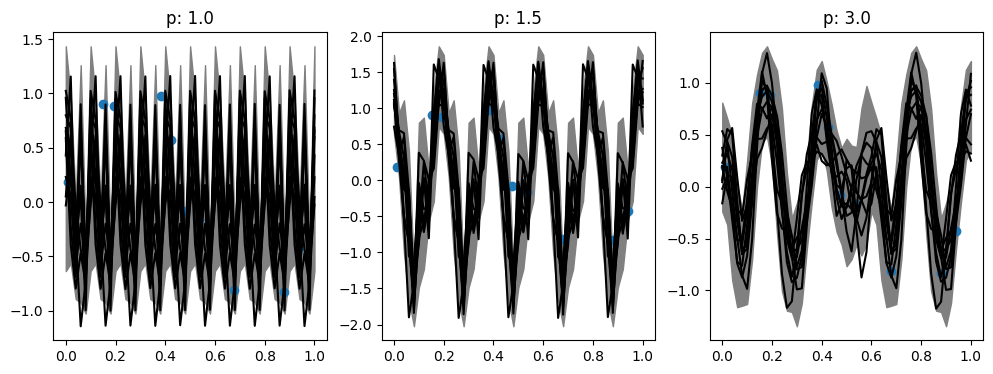

In [301]:
with torch.no_grad():
    length_scales = [0.1, 0.2, 0.6]
    periodicities = [1.0, 1.5, 3.0]
    fig, axs = plt.subplots(1,3, figsize=(4*3, 4*1))
    for i in range(3):
        with gpytorch.settings.prior_mode(False):
            if use_periodic:
                model.covar_module.base_kernel.period_length = length_scales[i]
                axs[i].set_title("p: %.1f"%periodicities[i])
                print(model.covar_module.base_kernel.period_length)
            else:
                model.covar_module.base_kernel.lengthscale = length_scales[i]
                axs[i].set_title(r"$\ell$: %.1f"%length_scales[i])
                print(model.covar_module.base_kernel.lengthscale)

            dist = model(test_x)
        plot_samples_1d(axs[i], dist, 10)
        
        axs[i].scatter(train_x, train_y)
    plt.show()

In [302]:
class CovNNOne(gpytorch.kernels.Kernel):
    has_lengthscale = True

    # this is the kernel function
    def forward(self, x1, x2, diag=False, **params):
        # apply lengthscale
        x1_ = torch.column_stack((x1, torch.ones((x1.size(-2)))))
        x2_ = torch.column_stack((x2, torch.ones((x2.size(-2)))))
        x1_ = x1_.div(self.lengthscale)
        x2_ = x2_.div(self.lengthscale)
        Spq = torch.matmul(x1_, x2_.T)
        Spp = 1 + torch.matmul(x1_, x1_.T)
        Sqq = 1 + torch.matmul(x2_, x2_.T)
        K = (2/math.pi)*torch.arcsin((Spq/(torch.sqrt(Spp*Sqq))))
        if diag:
            return K.diagonal()
        else:   
            return K
    
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(CovNNOne())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
fit(model, likelihood)

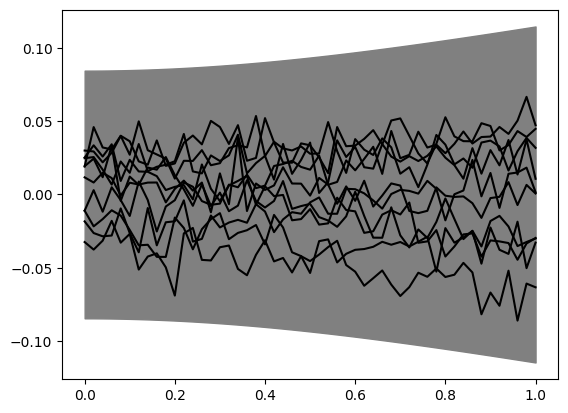

In [303]:
fig, ax = plt.subplots()
model.eval()
likelihood.eval()

with gpytorch.settings.prior_mode(True):
    prior = model(test_x)
plot_samples_1d(ax, prior, 10)

In [304]:
kernel = CovNNOne()
x_ = torch.linspace(-4, 4, 51).unsqueeze(1)
K = kernel.forward(x_, x_)

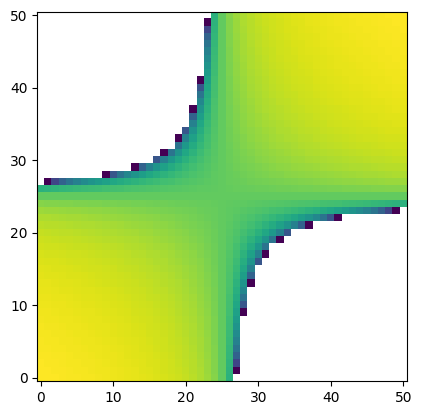

In [305]:
with torch.no_grad():
    plt.imshow(K, origin="lower")

In [306]:
K

tensor([[0.8504, 0.8476, 0.8446,  ...,    nan,    nan,    nan],
        [0.8476, 0.8447, 0.8417,  ...,    nan,    nan,    nan],
        [0.8446, 0.8417, 0.8386,  ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan,  ..., 0.8386, 0.8417, 0.8446],
        [   nan,    nan,    nan,  ..., 0.8417, 0.8447, 0.8476],
        [   nan,    nan,    nan,  ..., 0.8446, 0.8476, 0.8504]],
       grad_fn=<MulBackward0>)